# Apresentação do problema

A rotatividade em empresas representa custos não apenas de uma nova contratação, mas também a perda do conhecimento já instalado e futuras entregas que a pessoa poderia realizar. Entender quais pessoas estão mais propensas a sair da empresa permite a decisão de intervir ou não no caso tentado reverter a situação. Essa análise tem objetivo identificar fatores com maior correlação com a saída de empregados e a elaboração de um model preditivo que permita a identificação de casos futuros.


## 1. Inspeção, limpeza e preparação dos dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import warnings

warnings.filterwarnings('ignore')

In [2]:
INPUT_FILEPATH = "data/HR_Engagement_Sat_Sales_UpdatedV4.0.csv"
TARGET = "left_Company"
N_FOLDS = 5

In [3]:
data_raw = pd.read_csv(INPUT_FILEPATH)

In [4]:
data_raw.shape

(14999, 62)

In [5]:
data_raw.head()

,ID,Name,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending Perf,Talent_Level,...,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,1,BRADDY,Operations,US,VP,NaN,0,1.0,3,6,...,2,2,2,2,2,1,5,1841,61,9
1,2,BORST,Sales,UK,Senior Director,NaN,0,NaN,3,6,...,4,1,3,2,5,1,5,1990,90,8
2,3,BIRDWELL,Finance,France,Senior Director,NaN,0,NaN,3,6,...,2,5,2,2,4,4,4,3193,80,8
3,4,BENT,Human Resources,China,Senior Director,NaN,0,NaN,3,6,...,5,1,1,2,4,4,1,3248,77,6
4,5,BAZAN,IT,Korea,Director,NaN,0,NaN,3,6,...,5,3,5,1,2,5,4,3149,80,10


In [6]:
data_raw.dtypes  

ID                                         int64
Name                                      object
Department                                object
GEO                                       object
Role                                      object
Rising_Star                              float64
Will_Relocate                              int64
Critical                                 float64
Trending Perf                              int64
Talent_Level                               int64
Validated_Talent_Level                     int64
Percent_Remote                           float64
EMP_Sat_OnPrem_1                         float64
EMP_Sat_OnPrem_2                         float64
EMP_Sat_OnPrem_3                         float64
EMP_Sat_OnPrem_4                         float64
EMP_Sat_OnPrem_5                         float64
EMP_Sat_Remote_1                           int64
EMP_Sat_Remote_2                           int64
EMP_Sat_Remote_3                           int64
EMP_Sat_Remote_4    

**OBSERVAÇÕES**   
Podemos ver um total de 62 colunas sendo algumas não numéricas que precisarão ser encodadas.   
As features ID e Name não são significativas para o processo de análise e serão desconsideradas.  

Algumas colunas possuem títulos não explicativos como **Emp_Competitive_1** e estão descritas no arquivo codebook.txt neste repositório. As descrições foram retiradas do Kaggle e redigidas pelos autores do dataset. Entretanto para as colunas mencionadas, a explicação não dá o contexto necessário para entendimento cmpleto da feature, como foi coletado ou ainda, o que cada valor representa. Para fins dessa análise, serão mantidas apenas a coluna nº de cada um desses conjuntos de colunas similares, sob a premissa de leitura das labels como "mais é melhor". Caso o dataset tivesse sido fornecido por um cliente, seria mais provável de obter as explicações necessárias.

As colunas **batimento cardiaco, contagem de passos ou distância do computador** também não são relevantes para o problema em análise e também serão desconsideradas.  
As colunas **women_leave** e **men_leave** repetem informações já apresentadas na tabela, uma vez que temos a informação do sexo bem como de se a pessoa saiu ou não da empresa. Essas colunas serão desconsideradas.
A coluna **CSR Factor** está marcada como 'ignore' e será descondiderada


In [7]:
y = data_raw[TARGET]
X = data_raw.drop(columns=['ID', 'Name', 'Emp_Collaborative_2', 'Emp_Collaborative_3', 'Emp_Collaborative_4', 
                           'Emp_Collaborative_5', 'Emp_Competitive_2', 'Emp_Competitive_3', 'Emp_Competitive_4', 'Emp_Competitive_5',
                          'Emp_Work_Status_3', 'Emp_Work_Status_4', 'Emp_Work_Status_5', 'EMP_Sat_OnPrem_2', 'EMP_Sat_OnPrem_3', 'EMP_Sat_OnPrem_4', 'EMP_Sat_OnPrem_5',
                          'EMP_Sat_Remote_2', 'EMP_Sat_Remote_3', 'EMP_Sat_Remote_4', 'EMP_Sat_Remote_5', 'EMP_Engagement_2', 'EMP_Engagement_3',
                          'EMP_Engagement_4', 'EMP_Engagement_5', 'Sensor_StepCount', 'Sensor_Heartbeat(Average/Min)', 'Sensor_Proximity(1-highest/10-lowest)',
                          'Women_Leave', 'Men_Leave', 'CSR Factor', TARGET])
X = X.rename(columns={'Trending Perf':'Trending_Perf'})

In [8]:
y.unique()

array([0, 1])

In [9]:
X.dtypes

Department                 object
GEO                        object
Role                       object
Rising_Star               float64
Will_Relocate               int64
Critical                  float64
Trending_Perf               int64
Talent_Level                int64
Validated_Talent_Level      int64
Percent_Remote            float64
EMP_Sat_OnPrem_1          float64
EMP_Sat_Remote_1            int64
EMP_Engagement_1            int64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident               int64
promotion_last_5years       int64
sales                      object
salary                     object
Gender                     object
LinkedIn_Hits               int64
Emp_Work_Status2            int64
Emp_Identity                int64
Emp_Role                    int64
Emp_Position                int64
Emp_Title                   int64
Emp_Competitive_1           int64
Emp_Collaborat

In [10]:
duplicate_rows = X[X.duplicated()]
duplicate_rows.shape

(0, 30)

In [11]:
X.head()

,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending_Perf,Talent_Level,Validated_Talent_Level,Percent_Remote,...,salary,Gender,LinkedIn_Hits,Emp_Work_Status2,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Emp_Competitive_1,Emp_Collaborative_1
0,Operations,US,VP,NaN,0,1.0,3,6,6,0.4,...,low,M,5,4,1,1,2,1,2,2
1,Sales,UK,Senior Director,NaN,0,NaN,3,6,6,0.4,...,low,F,58,3,2,1,2,1,2,3
2,Finance,France,Senior Director,NaN,0,NaN,3,6,6,0.4,...,medium,F,42,2,1,1,2,2,1,2
3,Human Resources,China,Senior Director,NaN,0,NaN,3,6,6,0.4,...,high,M,37,3,2,1,2,1,1,1
4,IT,Korea,Director,NaN,0,NaN,3,6,6,0.4,...,low,F,6,4,1,1,2,1,1,5


In [12]:
X.isnull().sum()

Department                    0
GEO                           0
Role                          0
Rising_Star               14978
Will_Relocate                 0
Critical                  14519
Trending_Perf                 0
Talent_Level                  0
Validated_Talent_Level        0
Percent_Remote                0
EMP_Sat_OnPrem_1            128
EMP_Sat_Remote_1              0
EMP_Engagement_1              0
last_evaluation               0
number_project                0
average_montly_hours          0
time_spend_company            0
Work_accident                 0
promotion_last_5years         0
sales                         0
salary                        0
Gender                        0
LinkedIn_Hits                 0
Emp_Work_Status2              0
Emp_Identity                  0
Emp_Role                      0
Emp_Position                  0
Emp_Title                     0
Emp_Competitive_1             0
Emp_Collaborative_1           0
dtype: int64

In [13]:
print(X.Rising_Star.unique())
print(X.Critical.unique())
print(X.EMP_Sat_OnPrem_1.unique())
print(X.EMP_Sat_Remote_1.unique())
print(X.EMP_Engagement_1.unique())
print(X.Emp_Work_Status2.unique())

[nan  1.]
[ 1. nan]
[ 3. nan]
[2 3 5]
[5 1]
[4 3 2 1 5]


**OBSERVAÇÕES**   
As colunas que apresentam valores faltantes Rising Star e Critical são valores não encodados e trazem ambiguidade. Os exemplos com NaN se referem a valores não coletados ou a pessoas que não representam Rising STars, por exemplo? Para essa análise, o NaN ser´ainterpretado como uma pessoa que não é uma Risign Star. Essa premissa deveria ser clarificada junto ao cliente. 

Quanto à coluna EMP_Sat_OnPrem_1, os valores únicos 3 e Nan torna a interpretação desse conteúdo muito obscuro. Anslisando os valores únicos das colunas semelhantes observamos o conteúdo não parece muito interpretável, então serão removidos com exceção de Emp_Work_Status2.

In [14]:
X = X.drop(columns=['EMP_Sat_OnPrem_1', 'EMP_Sat_Remote_1', 'EMP_Engagement_1'])

In [18]:
# As colunas que contém NaN foram interpretadas como False em uma feature do tipo binária
X = X.fillna(0)

In [19]:
X.head()

,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending_Perf,Talent_Level,Validated_Talent_Level,Percent_Remote,...,salary,Gender,LinkedIn_Hits,Emp_Work_Status2,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Emp_Competitive_1,Emp_Collaborative_1
0,Operations,US,VP,0.0,0,1.0,3,6,6,0.4,...,low,M,5,4,1,1,2,1,2,2
1,Sales,UK,Senior Director,0.0,0,0.0,3,6,6,0.4,...,low,F,58,3,2,1,2,1,2,3
2,Finance,France,Senior Director,0.0,0,0.0,3,6,6,0.4,...,medium,F,42,2,1,1,2,2,1,2
3,Human Resources,China,Senior Director,0.0,0,0.0,3,6,6,0.4,...,high,M,37,3,2,1,2,1,1,1
4,IT,Korea,Director,0.0,0,0.0,3,6,6,0.4,...,low,F,6,4,1,1,2,1,1,5


## Visualizações das features

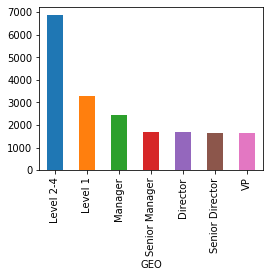

In [63]:
X.GEO.value_counts().plot(kind='bar', figsize=(4,3))
plt.xlabel("GEO");
X.Role.value_counts().plot(kind='bar', figsize=(4,3))

## Encoding

In [ ]:
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 259 kB 1.7 MB/s 
     |████████████████████████████████| 599 kB 2.7 MB/s 
     |████████████████████████████████| 25.9 MB 8.3 kB/s 
     |████████████████████████████████| 125 kB 3.2 MB/s 
     |████████████████████████████████| 11.5 MB 11 kB/s 
     |████████████████████████████████| 6.5 MB 4.2 MB/s 
     |████████████████████████████████| 3.1 MB 3.1 MB/s 
     |████████████████████████████████| 64 kB 1.0 MB/s 
     |████████████████████████████████| 61 kB 340 kB/s 
     |████████████████████████████████| 68 kB 83 kB/s 
     |████████████████████████████████| 59 kB 2.2 MB/s 
     |████████████████████████████████| 10.5 MB 7.4 MB/s 
     |████████████████████████████████| 108 kB 5.3 MB/s 
     |████████████████████████████████| 83 kB 851 kB/s 
     |████████████████████████████████| 3.6 MB 2.8 MB/s 
     |████████████████████████████████| 2.2 MB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 3.6 MB/s 
     |█████████████████████████████

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(X, title='Pandas Profiling Report')